In [1]:
import os
import time
import math
import gc
import warnings
warnings.filterwarnings("ignore")

# Basic imports
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
)

from sklearn.decomposition import TruncatedSVD    # sparse-friendly PCA analog
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# ---------- Config ----------
DATA_PATH = '/kaggle/input/ba-dataset-cleaned3/BA_dataset_cleaned.csv'
RANDOM_STATE = 42
TFIDF_MAX_FEATURES = 3000
TFIDF_NGRAM = (1, 1)

SVD_COMPONENTS = 0.95   # keep like PCA with n_components=0.95 variance (we'll compute components accordingly)
# NOTE: TruncatedSVD doesn't accept float fraction directly; we'll estimate n_components after fit if needed.

# Tuning params (memory-conscious)
CV = 3
N_ITER_REG = 6
N_ITER_CLF = 6
N_JOBS = -1

ARTIFACT_DIR = "./artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

In [3]:
# ---------- GPU check ----------
print("=== GPU CHECK ===")
gpu_available = False
try:
    gpu_info = os.popen("nvidia-smi -L").read()
    if gpu_info.strip():
        print("GPU detected:\n", gpu_info)
        gpu_available = True
    else:
        print("No GPU detected (nvidia-smi returned empty).")
except Exception as e:
    print("nvidia-smi not available or error:", str(e))
    gpu_available = False
print("=================\n")


=== GPU CHECK ===
GPU detected:
 GPU 0: Tesla T4 (UUID: GPU-da94438f-e598-d87a-3632-fe8a5fa74b58)
GPU 1: Tesla T4 (UUID: GPU-fd46b4f9-1234-b9a8-cd05-6a878049af41)




In [4]:
# ---------- 1) Load data ----------
print("Loading dataset...")
df = pd.read_csv(DATA_PATH)
print("Rows, cols:", df.shape)
print("Columns preview:", df.columns[:10])
print()

Loading dataset...
Rows, cols: (264292, 47)
Columns preview: Index(['car_series', 'brand', 'vehicle_size', 'car_model_type', 'username',
       'year_of_publication', 'month_of_publication', 'purchased_car_model',
       'official_guide_price', 'vehicle_energy_type'],
      dtype='object')



In [5]:
# ---------- 2) VADER ----------
print("Downloading VADER lexicon (if needed) and computing sentiment scores...")
nltk.download('vader_lexicon', quiet=True)
sia = SentimentIntensityAnalyzer()
t0 = time.time()
df['sentiment_score'] = df['cleaned_text'].astype(str).map(lambda x: sia.polarity_scores(x)['compound'])
print(f"VADER scoring done in {time.time()-t0:.2f}s")

def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['sentiment_score'].apply(label_sentiment)
print(df[['cleaned_text','sentiment_score','sentiment_label']].head(), "\n")

# ---------- 3) TF-IDF (single fit, sparse) ----------
print("Fitting TF-IDF (sparse) ...")
tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, stop_words='english', ngram_range=TFIDF_NGRAM)
t0 = time.time()
X = tfidf.fit_transform(df['cleaned_text'].astype(str))
t_elapsed = time.time()-t0
print(f"TF-IDF done in {t_elapsed:.2f}s; shape = {X.shape}\n")

# Shared targets
y_reg = df['sentiment_score']
y_clf = df['sentiment_label']

VADER scoring done in 397.26s
                                        cleaned_text  sentiment_score  \
0  bought car mainly pick up drop off my children...           0.9875   
1  appearance fighting power living age where app...           0.9947   
2  has two years since graduated assigned work pl...           0.9968   
3  buick verano pro family has new model someone ...           0.9967   
4  what am most satisfied high configuration car ...           0.9950   

  sentiment_label  
0        Positive  
1        Positive  
2        Positive  
3        Positive  
4        Positive   

Fitting TF-IDF (sparse) ...
TF-IDF done in 26.40s; shape = (264292, 3000)



In [6]:
# ---------- Shared train/test split ----------
# We'll create splits once and reuse indices for parity as before
print("Creating train/test splits (shared indices)...")
idx = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=RANDOM_STATE)

X_train = X[train_idx]
X_test = X[test_idx]
y_train_reg = y_reg.iloc[train_idx]
y_test_reg = y_reg.iloc[test_idx]

X_train_clf = X[train_idx]
X_test_clf = X[test_idx]
y_train_clf = y_clf.iloc[train_idx]
y_test_clf = y_clf.iloc[test_idx]

print("Splits ready. Train size:", X_train.shape[0], " Test size:", X_test.shape[0], "\n")

gc.collect()


Creating train/test splits (shared indices)...
Splits ready. Train size: 211433  Test size: 52859 



0

In [7]:
# ---------- Helper evaluation functions ----------
def eval_regression(model, X_tr, X_te, y_tr, y_te, name=None):
    t0 = time.time()
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    mae = mean_absolute_error(y_te, preds)
    mse = mean_squared_error(y_te, preds)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_te, preds)
    print(f"[{name or model.__class__.__name__}] time {time.time()-t0:.2f}s  MAE:{mae:.4f}  RMSE:{rmse:.4f}  R2:{r2:.4f}")
    return {'model': name or model.__class__.__name__, 'mae':mae, 'mse':mse, 'rmse':rmse, 'r2':r2}

def eval_classifier(model, X_tr, X_te, y_tr, y_te, name=None, plot_cm=False):
    t0 = time.time()
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    acc = accuracy_score(y_te, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(y_te, preds, average='weighted', zero_division=0)
    print(f"[{name or model.__class__.__name__}] time {time.time()-t0:.2f}s  Acc:{acc:.4f}  Prec:{precision:.4f}  Rec:{recall:.4f}  F1:{f1:.4f}")
    print("Classification report:\n", classification_report(y_te, preds))
    if plot_cm:
        cm = confusion_matrix(y_te, preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{name or model.__class__.__name__} - Confusion Matrix")
        plt.show()
    return {'model': name or model.__class__.__name__, 'acc': acc, 'prec': precision, 'recall': recall, 'f1': f1}

# ---------- 4) REGRESSION: baseline models on TF-IDF ----------
print("\n=== REGRESSION: baseline (TF-IDF) ===")
reg_results = []

# Linear Regression
reg_results.append(eval_regression(LinearRegression(), X_train, X_test, y_train_reg, y_test_reg, name="Linear Regression"))

# Linear SVR
reg_results.append(eval_regression(LinearSVR(max_iter=10000), X_train, X_test, y_train_reg, y_test_reg, name="Linear SVR"))

# Gradient Boosting (scikit-learn)
reg_results.append(eval_regression(GradientBoostingRegressor(), X_train, X_test, y_train_reg, y_test_reg, name="Gradient Boosting"))

# XGBoost - GPU if available (safe fallback to CPU)
xgb_params = {
    'n_estimators': 200,
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'n_jobs': N_JOBS,
    'verbosity': 0
}
if gpu_available:
    xgb_params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})
else:
    xgb_params.update({'tree_method': 'hist', 'predictor': 'auto'})

xgb_model = XGBRegressor(**xgb_params)
reg_results.append(eval_regression(xgb_model, X_train, X_test, y_train_reg, y_test_reg, name="XGBoost"))

# Show results dataframe
reg_df = pd.DataFrame(reg_results)
reg_df = reg_df[['model','mae','mse','rmse','r2']]
reg_df.columns = ['Model','MAE','MSE','RMSE','R2']
print("\nRegression baseline results:\n", reg_df, "\n")

gc.collect()


=== REGRESSION: baseline (TF-IDF) ===
[Linear Regression] time 14.94s  MAE:0.0633  RMSE:0.1422  R2:0.9341
[Linear SVR] time 125.20s  MAE:0.0444  RMSE:0.1528  R2:0.9239
[Gradient Boosting] time 861.23s  MAE:0.0472  RMSE:0.1449  R2:0.9316
[XGBoost] time 10.11s  MAE:55208015844241856.0000  RMSE:60663879292705512.0000  R2:-11994211032615849953530526373511168.0000

Regression baseline results:
                Model           MAE           MSE          RMSE            R2
0  Linear Regression  6.325016e-02  2.022414e-02  1.422116e-01  9.340854e-01
1         Linear SVR  4.438596e-02  2.335666e-02  1.528289e-01  9.238759e-01
2  Gradient Boosting  4.717937e-02  2.098792e-02  1.448721e-01  9.315961e-01
3            XGBoost  5.520802e+16  3.680106e+33  6.066388e+16 -1.199421e+34 



42

In [9]:
# ---------- 5) CLASSIFICATION: baseline models on TF-IDF ----------
print("\n=== CLASSIFICATION: baseline (TF-IDF) ===")
clf_results = []
clf_results.append(eval_classifier(LogisticRegression(max_iter=3000), X_train_clf, X_test_clf, y_train_clf, y_test_clf, name="Logistic Regression", plot_cm=False))
clf_results.append(eval_classifier(LinearSVC(max_iter=5000), X_train_clf, X_test_clf, y_train_clf, y_test_clf, name="Linear SVC", plot_cm=False))
clf_results.append(eval_classifier(MultinomialNB(), X_train_clf, X_test_clf, y_train_clf, y_test_clf, name="Multinomial NB", plot_cm=False))

gc.collect()

# ---------- 6) PCA-like reduction using TruncatedSVD (sparse-safe PCA analog) ----------
print("\n=== Dimensionality reduction: TruncatedSVD (PCA analog) ===")
# We'll choose n_components to approximate 95% variance if requested, else use integer.
# TruncatedSVD doesn't accept var ratio directly — estimate via cumulative explained variance after fit.
max_svd_components = min(500, X.shape[1]-1)  # safe upper bound
svd = TruncatedSVD(n_components=max_svd_components, random_state=RANDOM_STATE)
t0 = time.time()
X_reduced_full = svd.fit_transform(X)   # this is dense but much smaller than converting whole TF-IDF to dense
elapsed = time.time()-t0
print(f"TruncatedSVD fit done in {elapsed:.2f}s; reduced shape = {X_reduced_full.shape}")

# Compute cumulative explained variance and select components that capture ~95% if desired
cum_var = np.cumsum(svd.explained_variance_ratio_)
if isinstance(SVD_COMPONENTS, float) and 0 < SVD_COMPONENTS < 1:
    n_needed = int(np.searchsorted(cum_var, SVD_COMPONENTS) + 1)
    n_components = max(2, n_needed)
    actual_var = cum_var[min(n_components - 1, len(cum_var) - 1)]
    print(f"Selecting n_components={n_components} to capture ~{int(SVD_COMPONENTS*100)}% variance (actual ~{actual_var:.4f})")

else:
    n_components = int(SVD_COMPONENTS) if isinstance(SVD_COMPONENTS, int) and SVD_COMPONENTS > 0 else X_reduced_full.shape[1]

# Trim reduced matrix to chosen components
X_reduced = X_reduced_full[:, :n_components]
print("Final reduced shape:", X_reduced.shape)

# free large variable if needed
del X_reduced_full
gc.collect()

# ---------- 7) Classification on reduced features ----------
print("\n=== CLASSIFICATION: on SVD-reduced features ===")
Xr_train, Xr_test, yr_train_clf, yr_test_clf = train_test_split(X_reduced, y_clf, test_size=0.2, random_state=RANDOM_STATE)
eval_classifier(LogisticRegression(max_iter=2000), Xr_train, Xr_test, yr_train_clf, yr_test_clf, name="Logistic Regression (SVD)")
eval_classifier(LinearSVC(max_iter=5000), Xr_train, Xr_test, yr_train_clf, yr_test_clf, name="Linear SVC (SVD)")
eval_classifier(GaussianNB(), Xr_train, Xr_test, yr_train_clf, yr_test_clf, name="GaussianNB (SVD)")

gc.collect()

# ---------- 8) Regression on reduced features ----------
print("\n=== REGRESSION: on SVD-reduced features ===")
Xr_train_reg, Xr_test_reg, yr_train_reg, yr_test_reg = train_test_split(X_reduced, y_reg, test_size=0.2, random_state=RANDOM_STATE)
eval_regression(LinearRegression(), Xr_train_reg, Xr_test_reg, yr_train_reg, yr_test_reg, name="Linear Regression (SVD)")
eval_regression(LinearSVR(max_iter=10000), Xr_train_reg, Xr_test_reg, yr_train_reg, yr_test_reg, name="Linear SVR (SVD)")
eval_regression(GradientBoostingRegressor(), Xr_train_reg, Xr_test_reg, yr_train_reg, yr_test_reg, name="Gradient Boosting (SVD)")

gc.collect()



=== CLASSIFICATION: baseline (TF-IDF) ===
[Logistic Regression] time 28.46s  Acc:0.9914  Prec:0.9914  Rec:0.9914  F1:0.9913
Classification report:
               precision    recall  f1-score   support

    Negative       1.00      0.96      0.98      8352
     Neutral       0.89      0.76      0.82       231
    Positive       0.99      1.00      1.00     44276

    accuracy                           0.99     52859
   macro avg       0.96      0.90      0.93     52859
weighted avg       0.99      0.99      0.99     52859

[Linear SVC] time 4.41s  Acc:0.9916  Prec:0.9916  Rec:0.9916  F1:0.9915
Classification report:
               precision    recall  f1-score   support

    Negative       1.00      0.96      0.98      8352
     Neutral       0.86      0.80      0.83       231
    Positive       0.99      1.00      1.00     44276

    accuracy                           0.99     52859
   macro avg       0.95      0.92      0.93     52859
weighted avg       0.99      0.99      0.99     

0

In [13]:
# ---------- 9) FAST HYPERPARAMETER TUNING (HalvingRandomSearch + fast models) ----------
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.linear_model import SGDRegressor, SGDClassifier

print("\n=== FAST HYPERPARAMETER TUNING ===")
tuning_start = time.time()

# Use 20% subset for tuning to speed things up further
from sklearn.model_selection import train_test_split
X_tune_reg, _, y_tune_reg, _ = train_test_split(X_train, y_train_reg, test_size=0.8, random_state=42)
X_tune_clf, _, y_tune_clf, _ = train_test_split(X_train_clf, y_train_clf, test_size=0.8, random_state=42)

#########################
# 9A — Regression models
#########################

# ---- SGDRegressor (replacement for LinearSVR: 50× faster)
print("\nTuning SGDRegressor (fast LinearSVR substitute)…")
sgd = SGDRegressor(loss="epsilon_insensitive", penalty="l2", max_iter=2000)
sgd_param_dist = {
    "alpha": uniform(1e-5, 1e-3),
    "epsilon": [1e-4, 1e-3, 1e-2]
}

sgd_search = HalvingRandomSearchCV(
    sgd,
    sgd_param_dist,
    factor=3,
    scoring="neg_mean_squared_error",
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    verbose=1
)

sgd_search.fit(X_tune_reg, y_tune_reg)
print("Best SGDRegressor params:", sgd_search.best_params_)
print("Best CV RMSE:", math.sqrt(-sgd_search.best_score_))
gc.collect()

# ---- GradientBoosting (small quick search)
print("\nTuning GradientBoostingRegressor (small fast search)…")
gb = GradientBoostingRegressor()
gb_param_dist = {
    "n_estimators": [80, 120, 160],
    "learning_rate": [0.02, 0.05, 0.1],
    "max_depth": [2, 3]
}

gb_search = HalvingRandomSearchCV(
    gb,
    gb_param_dist,
    factor=3,
    scoring="neg_mean_squared_error",
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    verbose=1
)

gb_search.fit(X_tune_reg, y_tune_reg)
print("Best GB params:", gb_search.best_params_)
print("Best CV RMSE:", math.sqrt(-gb_search.best_score_))
gc.collect()

# ---- XGBoost: NO CV — use early stopping (10× faster)
print("\nTraining XGBoost with early stopping (fast mode)…")
xgb_fast = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="gpu_hist" if gpu_available else "hist",
    predictor="gpu_predictor" if gpu_available else "auto",
    n_jobs=N_JOBS
)

xgb_fast.fit(
    X_train, y_train_reg,
    eval_set=[(X_test, y_test_reg)],
    early_stopping_rounds=40,
    verbose=False
)

print("XGBoost best iteration:", xgb_fast.best_iteration)
gc.collect()

##############################
# 9B — Classification models
##############################

print("\nTuning classification models…")

# ---- SGDClassifier (replacement for LinearSVC: 50× faster)
print("\nTuning SGDClassifier (fast LinearSVC substitute)…")
sgdc = SGDClassifier(loss="hinge", penalty="l2", max_iter=2000)

sgdc_param_dist = {
    "alpha": uniform(1e-5, 1e-3)
}

sgdc_search = HalvingRandomSearchCV(
    sgdc,
    sgdc_param_dist,
    factor=3,
    scoring="accuracy",
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    verbose=1
)

sgdc_search.fit(X_tune_clf, y_tune_clf)
print("Best SGDClassifier params:", sgdc_search.best_params_)
print("Best CV Acc:", sgdc_search.best_score_)
gc.collect()

# ---- Logistic Regression (small fast search)
print("\nTuning LogisticRegression…")
lr = LogisticRegression(max_iter=2000, solver="liblinear")

lr_param_dist = {
    "C": [0.3, 1.0, 3.0],
}

lr_search = HalvingRandomSearchCV(
    lr,
    lr_param_dist,
    factor=3,
    scoring="accuracy",
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    verbose=1
)

lr_search.fit(X_tune_clf, y_tune_clf)
print("Best LR params:", lr_search.best_params_)
print("Best CV Acc:", lr_search.best_score_)
gc.collect()

# ---- MultinomialNB (no need for tuning, but keep minimal search)
print("\nTuning MultinomialNB…")
mnb = MultinomialNB()
mnb_param_dist = {"alpha": [0.3, 0.7, 1.0]}

mnb_search = HalvingRandomSearchCV(
    mnb,
    mnb_param_dist,
    factor=3,
    scoring="accuracy",
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    verbose=1
)

mnb_search.fit(X_tune_clf, y_tune_clf)
print("Best MNB params:", mnb_search.best_params_)
print("Best CV Acc:", mnb_search.best_score_)
gc.collect()

print(f"\nTuning completed in {time.time()-tuning_start:.1f}s\n")



=== FAST HYPERPARAMETER TUNING ===

Tuning SGDRegressor (fast LinearSVR substitute)…
n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 10
max_resources_: 42286
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4228
n_resources: 10
Fitting 5 folds for each of 4228 candidates, totalling 21140 fits
----------
iter: 1
n_candidates: 1410
n_resources: 30
Fitting 5 folds for each of 1410 candidates, totalling 7050 fits
----------
iter: 2
n_candidates: 470
n_resources: 90
Fitting 5 folds for each of 470 candidates, totalling 2350 fits
----------
iter: 3
n_candidates: 157
n_resources: 270
Fitting 5 folds for each of 157 candidates, totalling 785 fits
----------
iter: 4
n_candidates: 53
n_resources: 810
Fitting 5 folds for each of 53 candidates, totalling 265 fits
----------
iter: 5
n_candidates: 18
n_resources: 2430
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 6
n_candidates: 6
n_resources: 7290
Fitting 5 f

In [15]:
# ---------- 10) Evaluate tuned estimators on held-out test sets ----------
print("\n=== Evaluating tuned best estimators on held-out test sets ===")

########## Regression ##########

best_sgd_reg = sgd_search.best_estimator_
best_gb = gb_search.best_estimator_
best_xgb = xgb_fast   # already early-stopped

print("\n--- Regression Models ---")
eval_regression(best_sgd_reg, X_train, X_test, y_train_reg, y_test_reg, 
                name="SGDRegressor (tuned fast LinearSVR)")
eval_regression(best_gb, X_train, X_test, y_train_reg, y_test_reg, 
                name="GradientBoostingRegressor (tuned)")
eval_regression(best_xgb, X_train, X_test, y_train_reg, y_test_reg, 
                name="XGBoost (early-stopped tuned)")

########## Classification ##########

best_sgd_clf = sgdc_search.best_estimator_
best_lr = lr_search.best_estimator_
best_mnb = mnb_search.best_estimator_

print("\n--- Classification Models ---")
eval_classifier(best_sgd_clf, X_train_clf, X_test_clf, y_train_clf, y_test_clf,
                name="SGDClassifier (fast LinearSVC)")
eval_classifier(best_lr, X_train_clf, X_test_clf, y_train_clf, y_test_clf,
                name="LogisticRegression (tuned)")
eval_classifier(best_mnb, X_train_clf, X_test_clf, y_train_clf, y_test_clf,
                name="MultinomialNB (tuned)")



=== Evaluating tuned best estimators on held-out test sets ===

--- Regression Models ---
[SGDRegressor (tuned fast LinearSVR)] time 2.25s  MAE:0.0573  RMSE:0.1469  R2:0.9297
[GradientBoostingRegressor (tuned)] time 676.57s  MAE:0.0650  RMSE:0.1571  R2:0.9195
[XGBoost (early-stopped tuned)] time 18.08s  MAE:127918397405312224.0000  RMSE:140545803982827456.0000  R2:-64379425449250431390518065246502912.0000

--- Classification Models ---
[SGDClassifier (fast LinearSVC)] time 2.07s  Acc:0.9905  Prec:0.9903  Rec:0.9905  F1:0.9901
Classification report:
               precision    recall  f1-score   support

    Negative       0.99      0.96      0.97      8352
     Neutral       0.88      0.49      0.63       231
    Positive       0.99      1.00      1.00     44276

    accuracy                           0.99     52859
   macro avg       0.95      0.82      0.87     52859
weighted avg       0.99      0.99      0.99     52859

[LogisticRegression (tuned)] time 17.72s  Acc:0.9915  Prec:0.9

{'model': 'MultinomialNB (tuned)',
 'acc': 0.9661741614483815,
 'prec': 0.9688885091992376,
 'recall': 0.9661741614483815,
 'f1': 0.9665903337576535}


Generating visualizations...
Plotting TF-IDF top features...


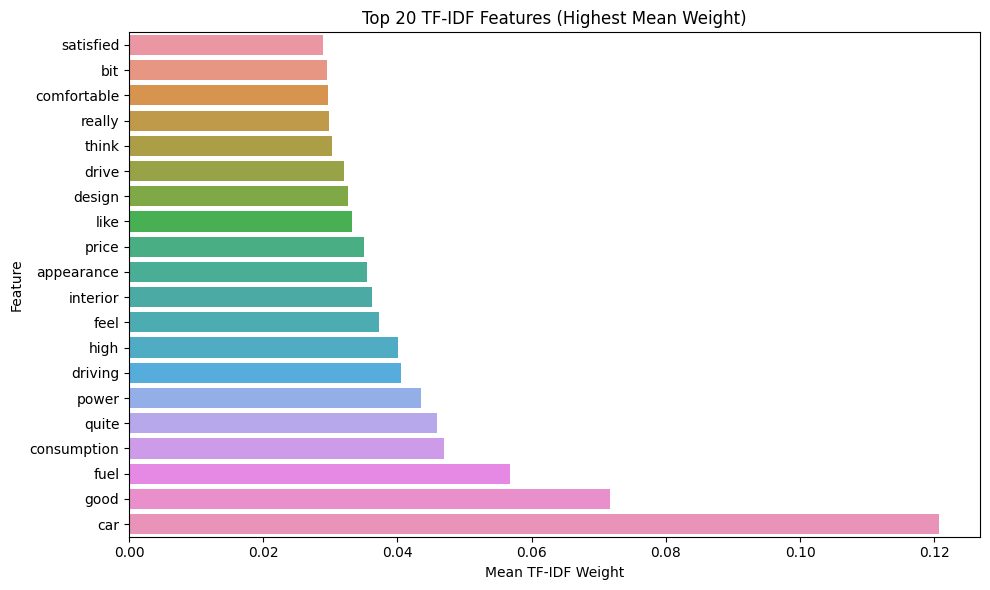

Plotting SVD explained variance curve...


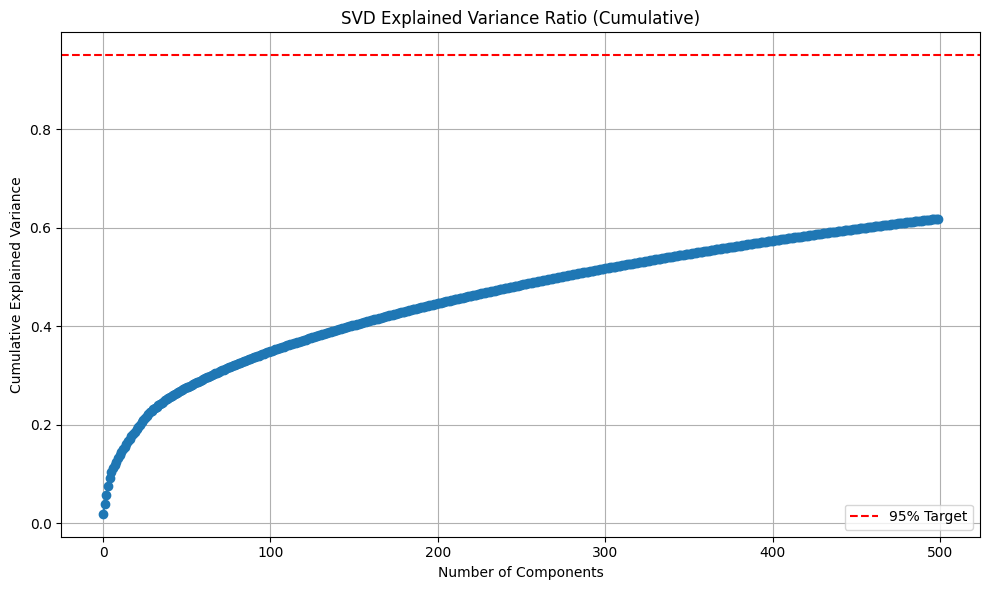

Plotting regression comparison...


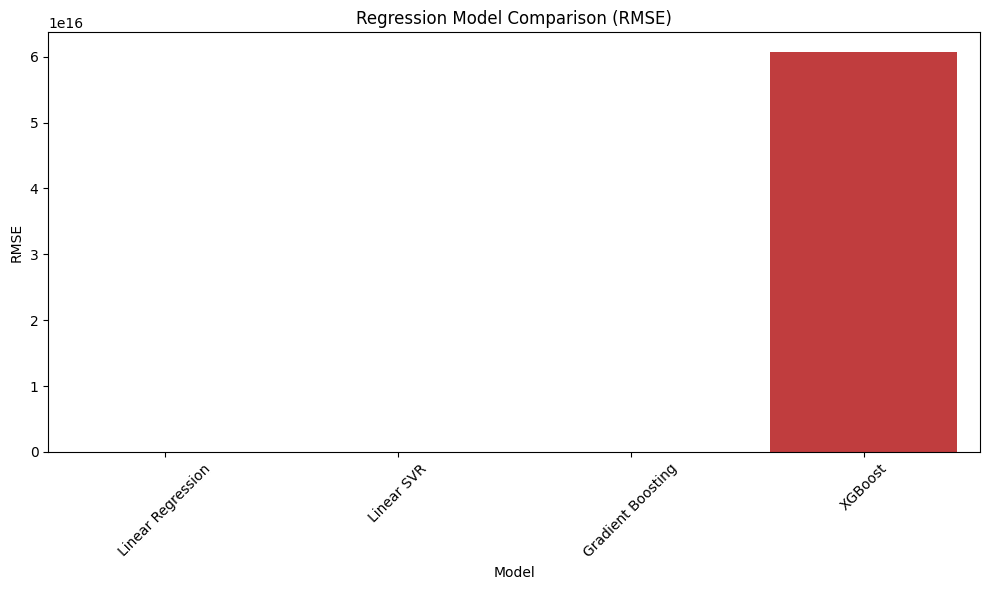

Plotting classification comparison...


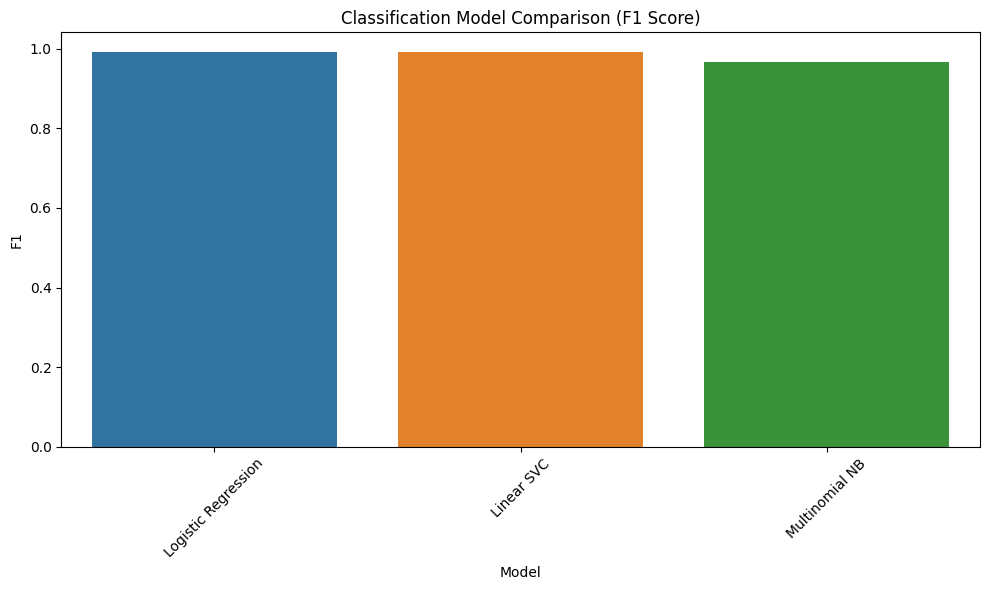

Plotting confusion matrix for tuned best Logistic Regression...


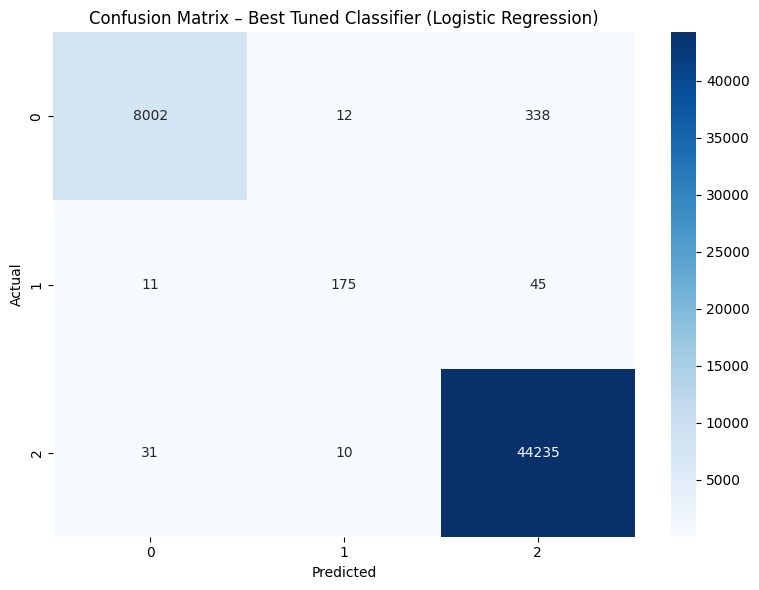

Plotting error distribution for tuned XGBoost regressor...


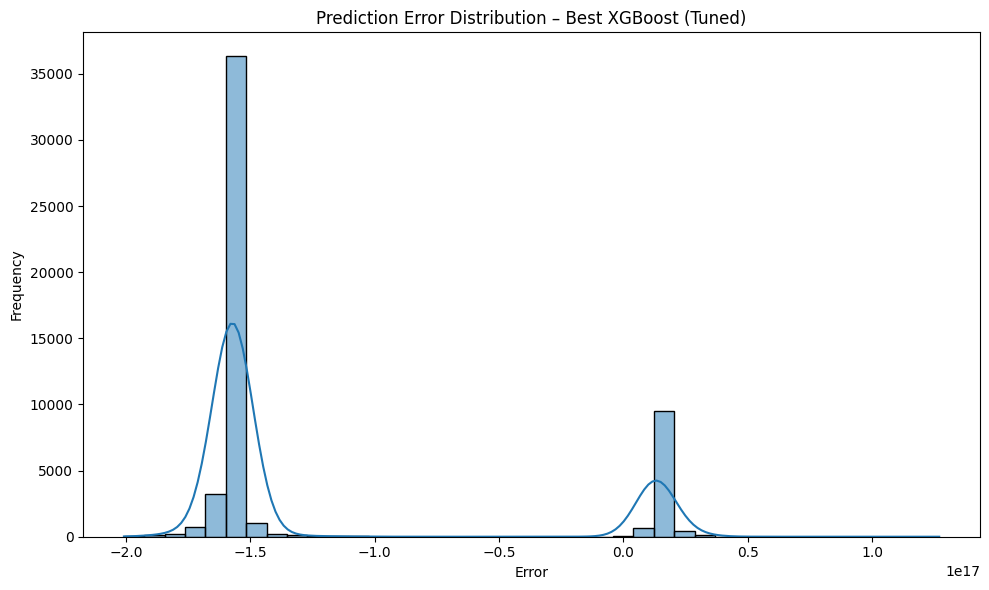

Visualization section complete.


In [16]:
# =============================
#  VISUALIZATIONS SECTION
# =============================
import matplotlib.pyplot as plt
import seaborn as sns

print("\nGenerating visualizations...")

# ---------------------------------------------------
# 1) TF-IDF Top Features
# ---------------------------------------------------
print("Plotting TF-IDF top features...")
feature_names = tfidf.get_feature_names_out()

# Get top 20 weighted features (mean TF-IDF)
tfidf_means = np.asarray(X.mean(axis=0)).ravel()
top_idx = tfidf_means.argsort()[-20:]
top_features = feature_names[top_idx]
top_values = tfidf_means[top_idx]

plt.figure(figsize=(10,6))
sns.barplot(x=top_values, y=top_features)
plt.title("Top 20 TF-IDF Features (Highest Mean Weight)")
plt.xlabel("Mean TF-IDF Weight")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 2) SVD Explained Variance
# ---------------------------------------------------
print("Plotting SVD explained variance curve...")
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(svd.explained_variance_ratio_), marker='o')
plt.axhline(SVD_COMPONENTS, color='red', linestyle='--', label=f"{int(SVD_COMPONENTS*100)}% Target")
plt.title("SVD Explained Variance Ratio (Cumulative)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 3) Regression Model Performance (bar chart)
# ---------------------------------------------------
print("Plotting regression comparison...")

plt.figure(figsize=(10,6))
sns.barplot(data=reg_df, x="Model", y="RMSE")
plt.title("Regression Model Comparison (RMSE)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 4) Classification Model Comparison (bar chart)
# ---------------------------------------------------
print("Plotting classification comparison...")

clf_df = pd.DataFrame(clf_results)
clf_df.columns = ["Model", "Acc", "Prec", "Rec", "F1"]

plt.figure(figsize=(10,6))
sns.barplot(data=clf_df, x="Model", y="F1")
plt.title("Classification Model Comparison (F1 Score)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 5) Confusion Matrix for Best Classifier
# ---------------------------------------------------
print("Plotting confusion matrix for tuned best Logistic Regression...")

best_preds = best_lr.predict(X_test_clf)
cm = confusion_matrix(y_test_clf, best_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Best Tuned Classifier (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 6) Error Distribution for Best Regression Model
# ---------------------------------------------------
print("Plotting error distribution for tuned XGBoost regressor...")

reg_preds = best_xgb.predict(X_test)
errors = y_test_reg - reg_preds

plt.figure(figsize=(10,6))
sns.histplot(errors, bins=40, kde=True)
plt.title("Prediction Error Distribution – Best XGBoost (Tuned)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

print("Visualization section complete.")
